In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import feather

In [2]:
DIR ="../input/riiid-test-answer-prediction/"
lectures = pd.read_csv(DIR+"lectures.csv")
questions = pd.read_csv(DIR+"questions.csv")
example_test = pd.read_csv(DIR+"example_test.csv")
train = pd.read_feather("../input/riid-train/train.feather")

# train
- row_id: (int64) ID code for the row.
- timestamp: (int64) the time between this user interaction and the first event completion from that user.
- user_id: (int32) ID code for the user.
- content_id: (int16) ID code for the user interaction
- content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
- task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before  seeing the explanations for any of them. Those three would all share a task_container_id.
- user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
- answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
- prior_question_elapsed_time: (float32) The average time it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
- prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

- content_type_id = 0なら、questions.csvと結合できる, content_type_id = 1なら、lectures.csvと結合できる

In [3]:
train.shape

(101230332, 10)

In [4]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,4294967295,None
1,1,56943,115,5716,0,2,2,1,37000,False
2,2,118363,115,128,0,0,0,1,55000,False
3,3,131167,115,7860,0,3,0,1,19000,False
4,4,137965,115,7922,0,4,1,1,11000,False


In [5]:
len(train.user_id.unique())

393656

In [6]:
train.user_id.unique()[:10]

array([  115,   124,  2746,  5382,  8623,  8701, 12741, 13134, 24418,
       24600], dtype=uint32)

In [7]:
train[train.user_id==2746] # task_container_id doesn't monotonically increase

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
76,76,0,2746,5273,0,0,1,0,4294967295,None
77,77,21592,2746,758,0,1,0,0,28000,False
78,78,49069,2746,5976,0,2,3,0,17000,False
79,79,72254,2746,236,0,3,3,1,24000,False
80,80,91945,2746,404,0,4,3,0,20000,False
81,81,111621,2746,382,0,5,0,1,16000,False
82,82,134341,2746,405,0,6,1,1,16000,False
83,83,234605,2746,873,0,7,3,1,19000,False
84,84,283894,2746,531,0,8,0,1,18000,True
85,85,328640,2746,775,0,9,3,0,18000,True


In [8]:
tmp = train[train.user_id==2746].copy()
tmp["task_container_id"] = tmp["task_container_id"].transform(lambda x: pd.factorize(x)[0]).astype('int16')
tmp
#train['task_container_id'] = (
#    train
#    .groupby('user_id')['task_container_id']
#    .transform(lambda x: pd.factorize(x)[0])
#    .astype('int16')
#)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
76,76,0,2746,5273,0,0,1,0,4294967295,None
77,77,21592,2746,758,0,1,0,0,28000,False
78,78,49069,2746,5976,0,2,3,0,17000,False
79,79,72254,2746,236,0,3,3,1,24000,False
80,80,91945,2746,404,0,4,3,0,20000,False
81,81,111621,2746,382,0,5,0,1,16000,False
82,82,134341,2746,405,0,6,1,1,16000,False
83,83,234605,2746,873,0,7,3,1,19000,False
84,84,283894,2746,531,0,8,0,1,18000,True
85,85,328640,2746,775,0,9,3,0,18000,True


In [9]:
train[train.user_id==115]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,4294967295,None
1,1,56943,115,5716,0,2,2,1,37000,False
2,2,118363,115,128,0,0,0,1,55000,False
3,3,131167,115,7860,0,3,0,1,19000,False
4,4,137965,115,7922,0,4,1,1,11000,False
5,5,157063,115,156,0,5,2,1,5000,False
6,6,176092,115,51,0,6,0,1,17000,False
7,7,194190,115,50,0,7,3,1,17000,False
8,8,212463,115,7896,0,8,2,1,16000,False
9,9,230983,115,7863,0,9,0,1,16000,False


In [10]:
tmp = train[train.user_id==115].copy()
tmp["task_container_id"] = tmp["task_container_id"].transform(lambda x: pd.factorize(x)[0]).astype('int16')
tmp

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,0,3,1,4294967295,None
1,1,56943,115,5716,0,1,2,1,37000,False
2,2,118363,115,128,0,2,0,1,55000,False
3,3,131167,115,7860,0,3,0,1,19000,False
4,4,137965,115,7922,0,4,1,1,11000,False
5,5,157063,115,156,0,5,2,1,5000,False
6,6,176092,115,51,0,6,0,1,17000,False
7,7,194190,115,50,0,7,3,1,17000,False
8,8,212463,115,7896,0,8,2,1,16000,False
9,9,230983,115,7863,0,9,0,1,16000,False


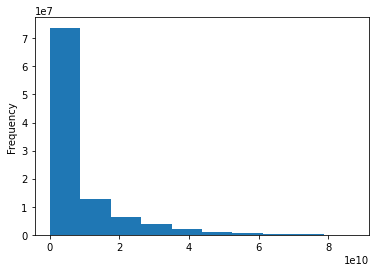

In [11]:
train.timestamp.plot(kind="hist")

In [12]:
train.content_id.value_counts()

6116     213605
6173     202106
4120     199372
175      195861
7876     190170
          ...  
10006         1
10007         1
10008         1
1484          1
21169         1
Name: content_id, Length: 13782, dtype: int64

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   row_id                          uint32
 1   timestamp                       uint64
 2   user_id                         uint32
 3   content_id                      uint16
 4   content_type_id                 uint8 
 5   task_container_id               uint16
 6   user_answer                     int8  
 7   answered_correctly              int8  
 8   prior_question_elapsed_time     uint32
 9   prior_question_had_explanation  object
dtypes: int8(2), object(1), uint16(2), uint32(3), uint64(1), uint8(1)
memory usage: 3.3+ GB


In [14]:
# null value in prior_question_had_explanation_only, but other variables include -1 as missing value 
train.isnull().sum()

row_id                                 0
timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation    392506
dtype: int64

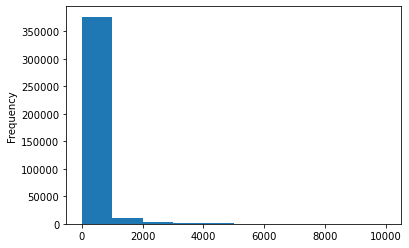

In [15]:
# data num per user_id
train.groupby("user_id").agg("max")["task_container_id"].plot(kind="hist")

In [16]:
train["content_type_id"].sum() / train.shape[0] # lectureはわずか2%

0.019352223402764303

In [17]:
train["prior_question_had_explanation"]

0             None
1            False
2            False
3            False
4            False
             ...  
101230327     True
101230328     True
101230329     True
101230330     True
101230331     True
Name: prior_question_had_explanation, Length: 101230332, dtype: object

# lecture
- lectures.csv: metadata for the lectures watched by users as they progress in their education.
- lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
- part: top level category code for the lecture.
- tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
- type_of: brief description of the core purpose of the lecture

In [18]:
lectures.shape

(418, 4)

In [19]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [20]:
lectures[lectures.type_of=="solving question"]["tag"].unique()

array([ 79, 156, 134,  80, 101,  74,  43, 109, 142, 140,   1,  26, 173,
         7,  64, 141, 124, 161,   4,  94,  70, 119, 177,  54,  50, 116,
        93, 136, 127,  53, 130,  13,  36,  62, 181, 164, 163,  85,  91,
         9,  28,  98, 159,  27, 149,  61, 166,  14, 113, 182,  55,  49,
       106,  47,  60, 179,  71,  82,  44,  25, 108,  96,   5, 152,  16,
        73, 178,  42,  40,   6, 157,  33,  51, 133,  48, 167,  68,  95,
        30, 174,  20,  66,  37,  45, 105, 151, 123, 114, 180,  89, 168,
        78, 111,  52,  34,   8, 184, 176,  72, 129, 128,  65, 125, 170,
       104,  69,   0])

In [21]:
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [22]:
lectures.tag.value_counts() # 一部タグに重複あり

136    7
116    6
134    6
27     6
161    6
      ..
99     1
57     1
90     1
83     1
187    1
Name: tag, Length: 151, dtype: int64

In [23]:
lectures.part.value_counts() # 一部タグに重複あり

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

In [24]:
lectures.type_of.value_counts() # 一部タグに重複あり

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

In [25]:
lectures.isnull().sum() # no missing value

lecture_id    0
tag           0
part          0
type_of       0
dtype: int64

# questions
- questions.csv: metadata for the questions posed to users.
- question_id: foreign key for the train/test content_id column, when the content type is question (0).
- bundle_id: code for which questions are served together.
- correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
- part: the relevant section of the TOEIC test.
- tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [26]:
questions.shape

(13523, 5)

In [27]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [28]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [29]:
len(questions.question_id.unique()) # question_id is unique

13523

In [30]:
len(questions.bundle_id.unique()) # bundle_id is not unique

9765

In [31]:
questions.part.value_counts()

5    5511
2    1647
3    1562
4    1439
6    1212
7    1160
1     992
Name: part, dtype: int64

In [32]:
questions.isnull().sum()

question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64

# combi of question and lecture

In [33]:
# https://stackoverflow.com/questions/16236684/apply-pandas-function-to-column-to-create-multiple-new-columns
# https://stackoverflow.com/questions/16228248/how-can-i-get-list-of-values-from-dict
def calc(tags):
    type_count = {'concept':0, 'solving question': 0, 'intention': 0, 'starter':0}
    try:
        tag_list = tags.split(" ")
        type_list = list(lectures[lectures.tag.isin(tag_list)]["type_of"])
    except:
        ans = list(type_count.values())
        return ans[0], ans[1], ans[2], ans[3] 
    for ele in type_list:
        type_count[ele] += 1
    ans = list(type_count.values())
    print(tag_list, type_list ,ans)
    return ans[0], ans[1], ans[2], ans[3] 
questions['concept'], questions['solving question'], questions['intention'], questions['starter'] = zip(*questions['tags'].map(calc))
#questions.apply(lambda x: calc(x), axis=1)

['51', '131', '162', '38'] ['concept', 'solving question'] [1, 1, 0, 0]
['131', '36', '81'] ['solving question', 'solving question', 'concept', 'solving question'] [1, 3, 0, 0]
['131', '101', '162', '92'] ['solving question', 'solving question', 'solving question', 'concept'] [1, 3, 0, 0]
['131', '149', '162', '29'] ['solving question', 'solving question', 'solving question', 'concept'] [1, 3, 0, 0]
['131', '5', '162', '38'] ['concept', 'solving question'] [1, 1, 0, 0]
['131', '149', '162', '81'] ['solving question', 'solving question', 'solving question', 'concept'] [1, 3, 0, 0]
['10', '94', '162', '92'] ['solving question', 'concept', 'solving question', 'solving question', 'solving question'] [1, 4, 0, 0]
['61', '110', '162', '29'] ['solving question', 'solving question', 'solving question', 'concept'] [1, 3, 0, 0]
['131', '13', '162', '92'] ['solving question', 'solving question', 'concept'] [1, 2, 0, 0]
['10', '164', '81'] ['solving question', 'concept'] [1, 1, 0, 0]
['131', '36',

In [34]:
lectures[lectures.tag.isin([131])]

,lecture_id,tag,part,type_of


In [35]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags,concept,solving question,intention,starter
0,0,0,0,1,51 131 162 38,1,1,0,0
1,1,1,1,1,131 36 81,1,3,0,0
2,2,2,0,1,131 101 162 92,1,3,0,0
3,3,3,0,1,131 149 162 29,1,3,0,0
4,4,4,3,1,131 5 162 38,1,1,0,0


- questionとlectureのタグは意味が違うっぽい..

# example_test
- row_id: (int64) ID code for the row.
- timestamp: (int64) the time between this user interaction and the first event completion from that user.
- user_id: (int32) ID code for the user.
- content_id: (int16) ID code for the user interaction
- content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
- task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
- user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
- answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
- prior_question_elapsed_time: (float32) The average time it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
- prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [36]:
example_test.head()

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN


In [37]:
train[train.user_id ==554169193]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
25924315,25924315,0,554169193,3927,0,0,1,1,4294967295,None
25924316,25924316,24904,554169193,939,0,1,0,1,23000,False
25924317,25924317,59273,554169193,6683,0,2,1,0,19000,False
25924318,25924318,95917,554169193,5658,0,3,3,1,30000,False
25924319,25924319,112132,554169193,6202,0,4,2,1,31000,False
...,...,...,...,...,...,...,...,...,...,...
25929669,25929669,13134944873,554169193,13469,0,4417,3,1,19000,True
25929670,25929670,13134970085,554169193,13307,0,4418,0,1,6000,True
25929671,25929671,13309652232,554169193,12256,0,4419,1,0,9000,True
25929672,25929672,13309683400,554169193,1074,0,4420,0,0,40000,True


In [38]:
# all user_id in test data is included in training data as well if the corresponding timestamp is not 0.
for i in example_test.user_id.unique():
    if i in list(train.user_id.unique()):
        print(i)
    else:
        print("!")

!
554169193
1720860329
288641214
1728340777
1364159702
1521618396
1317245193
1700555100
998511398
1422853669
1096784725
385471210
1202386221
2018567473
1233875513
891955351
1981166446
1637273633
2030979309
319060572
98059812
674533997
555691277
775113212
1219481379
1148874033
1281335472
2002570769
706626847
1357500007
1599808246
1305988022
1310228392
2093197291
1468996389
1838324752
2103436554
311890082
1817433235
1900527744
7792299


# public test

In [39]:
public_test = pd.read_csv("../input/riid-test/test.csv")

In [40]:
public_test

,row_id,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses,mean_user_accuracy,mean_accuracy_by_content,answered_correctly
0,74,275030867,8308,0,3,15000.0,0,"[1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 3, 0, 0, ...",0.500000,0.626737,0.660656
1,75,1305988022,396,0,4163,19000.0,1,0.5,0.5,0.596905,0.733943,0.662372
2,76,1310228392,11869,0,1458,26333.0,1,0.5,0.5,0.795016,0.412793,0.660814
3,77,1310228392,11871,0,1458,26333.0,1,0.5,0.5,0.795016,0.861466,0.665208
4,78,1310228392,11870,0,1458,26333.0,1,0.5,0.5,0.795016,0.455850,0.661772
5,79,1310228392,11872,0,1458,26333.0,1,0.5,0.5,0.795016,0.330109,0.660814
6,80,1310228392,11868,0,1458,26333.0,1,0.5,0.5,0.795016,0.809360,0.665208
7,81,1637273633,5935,0,3149,19000.0,1,0.5,0.5,0.645136,0.647611,0.663928
8,82,674533997,6000,0,1046,10000.0,1,0.5,0.5,0.623612,0.435323,0.658971
9,84,2093197291,12611,0,5448,28750.0,1,0.5,0.5,0.791287,0.713415,0.663928


In [41]:
train[train.user_id==275030867] #probably, the row in the test data represents first question answer of the user

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation


In [42]:
train[train.user_id==1305988022]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
61540482,61540482,0,1305988022,6453,0,0,0,0,4294967295,None
61540483,61540483,24918,1305988022,684,0,1,3,1,64000,False
61540484,61540484,57616,1305988022,5592,0,2,3,0,22000,False
61540485,61540485,98743,1305988022,5159,0,3,0,0,30000,False
61540486,61540486,143241,1305988022,6681,0,4,2,0,38000,False
...,...,...,...,...,...,...,...,...,...,...
61544677,61544677,31220308488,1305988022,911,0,4156,3,1,23000,True
61544678,61544678,31220393226,1305988022,735,0,4157,1,1,21000,True
61544679,61544679,31220463516,1305988022,815,0,4158,0,1,19000,True
61544680,61544680,31220533841,1305988022,427,0,4159,0,1,15000,True


In [43]:
train[train.user_id==1310228392]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
61719966,61719966,0,1310228392,7900,0,0,0,1,4294967295,None
61719967,61719967,23262,1310228392,7876,0,1,3,1,22000,False
61719968,61719968,48629,1310228392,175,0,2,0,0,21000,False
61719969,61719969,66683,1310228392,1278,0,3,3,1,23000,False
61719970,61719970,168490,1310228392,2064,0,4,1,1,16000,False
...,...,...,...,...,...,...,...,...,...,...
61722088,61722088,48578042019,1310228392,10125,0,1456,0,1,28666,True
61722089,61722089,48578042019,1310228392,10124,0,1456,2,1,28666,True
61722090,61722090,48578135018,1310228392,2584,0,1457,3,1,25666,True
61722091,61722091,48578135018,1310228392,2586,0,1457,3,1,25666,True


# how to make features

In [44]:
from tqdm import tqdm_notebook as tqdm

In [45]:
# preprocess
train = pd.read_feather("../input/riid-train/train.feather")
train = train[train.user_id.isin([115, 124, 2746, 5382, 8623,  8701, 12741, 13134, 24418, 24600])].copy()
train['task_container_id'] = (train.groupby('user_id')['task_container_id'].transform(lambda x: pd.factorize(x)[0]).astype('int16'))

In [46]:
# https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-count-in-groups-using-groupby
max_idx = train.groupby(['user_id'])['task_container_id'].transform(max) == train['task_container_id']
min_idx = train.groupby(['user_id'])['task_container_id'].transform(min) == train['task_container_id']
train[max_idx|min_idx]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,0,3,1,4294967295,None
43,43,668090043,115,3363,0,41,1,0,14333,False
44,44,668090043,115,3365,0,41,0,0,14333,False
45,45,668090043,115,3364,0,41,1,1,14333,False
46,46,0,124,7900,0,0,0,1,4294967295,None
72,72,571323,124,7218,0,15,3,0,6500,False
73,73,571323,124,7216,0,15,0,0,6500,False
74,74,571323,124,7217,0,15,3,0,6500,False
75,75,571323,124,7219,0,15,1,0,6500,False
76,76,0,2746,5273,0,0,1,0,4294967295,None


In [47]:
user_answers_df = train.groupby('user_id').agg({'answered_correctly': ['mean']}).copy()
user_answers_df.columns = ['correct_rate_before_ans']

In [48]:
def get_data(df, test_set=False):
    
    if test_set == False:
        df = df.loc[df['answered_correctly'] != -1].reset_index(drop=True)
        df.drop(["user_answer"], axis=1, inplace=True)
        
    correct_rate = np.array([])
    df = df.merge(questions[["question_id", "part"]], how="left", left_on=['content_id'], right_on=['question_id'])
    
    if test_set == False:
        for i, (ins_id, user_sample) in tqdm(enumerate(df.groupby('user_id', sort=False)), total=train.user_id.nunique(), desc='user_id', position=0):
            cum_correct_num = user_sample["answered_correctly"].cumsum().values
            cum_answer_num = [i+1 for i in range(user_sample.shape[0])]
            
            correct_rate_list = [cum_correct_num[i]/cum_answer_num[i] for i in range(len(cum_answer_num))]
            correct_rate_list = [-1] + correct_rate_list[:-1]
            correct_rate = np.concatenate([correct_rate, correct_rate_list])
            
        df["correct_rate_before_ans"] = correct_rate  
    else:
        df = df.merge(user_answers_df, how = 'left', on = 'user_id') #correct_rate_before_ans

    df.drop(["timestamp"], axis=1, inplace=True)
    df.fillna(value = -1, inplace = True)
    return df
train = get_data(train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [49]:
# target encoding + moving average not to cause target leakage
AGGS = [
    ('answered_correctly', 2, ['user_id'], ['mean']),
    ('answered_correctly', 3, ['user_id'], ['mean']),
]

for on, lag, by, hows in AGGS:

    agg = train.groupby(by)[on].apply(lambda x: (
        x
        .shift(1)
        .rolling(window=lag, min_periods=1)
        .agg(hows)
    ))
    agg = agg.rename(columns={
        how: f'{how}_of_last_{lag}_{on}_by_' + '_and_'.join(by)
        for how in hows
    })

    train = train.join(agg)

In [50]:
train[train.user_id==115]

,row_id,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,part,correct_rate_before_ans,mean_of_last_2_answered_correctly_by_user_id,mean_of_last_3_answered_correctly_by_user_id
0,0,115,5692,0,0,1,4294967295,-1,5692,5,-1.000000,NaN,NaN
1,1,115,5716,0,1,1,37000,False,5716,5,1.000000,1.0,1.000000
2,2,115,128,0,2,1,55000,False,128,1,1.000000,1.0,1.000000
3,3,115,7860,0,3,1,19000,False,7860,1,1.000000,1.0,1.000000
4,4,115,7922,0,4,1,11000,False,7922,1,1.000000,1.0,1.000000
5,5,115,156,0,5,1,5000,False,156,1,1.000000,1.0,1.000000
6,6,115,51,0,6,1,17000,False,51,1,1.000000,1.0,1.000000
7,7,115,50,0,7,1,17000,False,50,1,1.000000,1.0,1.000000
8,8,115,7896,0,8,1,16000,False,7896,1,1.000000,1.0,1.000000
9,9,115,7863,0,9,1,16000,False,7863,1,1.000000,1.0,1.000000


In [51]:
train.groupby("user_id").tail(2)#.groupby("user_id").agg("mean")["answered_correctly"]

,row_id,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,part,correct_rate_before_ans,mean_of_last_2_answered_correctly_by_user_id,mean_of_last_3_answered_correctly_by_user_id
44,44,115,3365,0,41,0,14333,False,3365,4,0.704545,0.0,0.333333
45,45,115,3364,0,41,1,14333,False,3364,4,0.688889,0.0,0.000000
74,74,124,7217,0,15,0,6500,False,7217,7,0.250000,0.0,0.000000
75,75,124,7219,0,15,0,6500,False,7219,7,0.241379,0.0,0.000000
93,94,2746,1014,0,18,0,19000,True,1014,2,0.588235,1.0,0.666667
94,95,2746,484,0,19,1,20000,True,484,2,0.555556,0.5,0.666667
218,222,5382,4728,0,126,0,20000,True,4728,5,0.682927,0.5,0.666667
219,223,5382,4070,0,127,0,22000,True,4070,5,0.677419,0.0,0.333333
327,334,8623,855,0,98,1,18000,True,855,2,0.635514,0.5,0.666667
328,335,8623,969,0,99,1,18000,True,969,2,0.638889,1.0,0.666667


In [52]:
train.groupby("user_id").tail(2).groupby("user_id").agg("mean")["answered_correctly"]
train.groupby("user_id").tail(3).groupby("user_id").agg("mean")["answered_correctly"]

user_id
115      0.333333
124      0.000000
2746     0.666667
5382     0.000000
8623     1.000000
8701     0.666667
12741    1.000000
13134    1.000000
24418    1.000000
24600    0.333333
Name: answered_correctly, dtype: float64

In [53]:
train.head(30)

,row_id,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,part,correct_rate_before_ans,mean_of_last_2_answered_correctly_by_user_id,mean_of_last_3_answered_correctly_by_user_id
0,0,115,5692,0,0,1,4294967295,-1,5692,5,-1.000000,NaN,NaN
1,1,115,5716,0,1,1,37000,False,5716,5,1.000000,1.0,1.000000
2,2,115,128,0,2,1,55000,False,128,1,1.000000,1.0,1.000000
3,3,115,7860,0,3,1,19000,False,7860,1,1.000000,1.0,1.000000
4,4,115,7922,0,4,1,11000,False,7922,1,1.000000,1.0,1.000000
5,5,115,156,0,5,1,5000,False,156,1,1.000000,1.0,1.000000
6,6,115,51,0,6,1,17000,False,51,1,1.000000,1.0,1.000000
7,7,115,50,0,7,1,17000,False,50,1,1.000000,1.0,1.000000
8,8,115,7896,0,8,1,16000,False,7896,1,1.000000,1.0,1.000000
9,9,115,7863,0,9,1,16000,False,7863,1,1.000000,1.0,1.000000
